# Exploratory Data Analysis


The dataset comprises medical data from patients, including physiological, demographic, and genetic features, aimed at diagnosing the presence of diabetes. The analysis focuses on uncovering patterns, trends, and insights that will assist in building a robust predictive model for diabetes diagnosis. Key aspects explored include the impact of glucose levels, BMI, age groups, and genetic predisposition on diabetes risk. The study also evaluates the performance of various machine learning models to select the most reliable classifier. Recommendations derived from these insights will help optimize diagnostic strategies, enabling early detection and intervention for individuals at risk of diabetes.

### Load libraries

This project utilizes a dataset based on the Pima Indians Diabetes Database from Kaggle (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). The dataset originates from the National Institute of Diabetes and Digestive and Kidney Diseases and is specifically designed to diagnostically predict whether or not a patient has diabetes, based on a series of diagnostic measurements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

### Import Data

In [2]:
file_path = '/content/diabetes.csv'
df = pd.read_csv(file_path)

print("DataFrame loaded successfully!")

DataFrame loaded successfully!


In [ ]:
print(f"Total number of rows in the dataset: {len(df)}")

Total number of rows in the dataset: 892


### Part 1: Data quality

Dropping fully empty rows:

In [ ]:
fully_empty_rows = df[df.isnull().all(axis=1)]
print(f"Number of fully empty rows: {len(fully_empty_rows)}")

partially_empty_rows = df[df.isnull().any(axis=1) & ~df.isnull().all(axis=1)]
print(f"Number of partially empty rows: {len(partially_empty_rows)}")

print(f"Data before dropping fully empty rows: {len(df)} rows")
df = df.dropna(how='all')
print(f"Data after dropping fully empty rows: {len(df)} rows")

Number of fully empty rows: 60
Number of partially empty rows: 3
Data before dropping fully empty rows: 892 rows
Data after dropping fully empty rows: 832 rows


In [ ]:
high_missing_rows = df[df.isnull().mean(axis=1) > 0.5]
print("Rows with more than 50% missing values:")
print(high_missing_rows)

Rows with more than 50% missing values:
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


Dealing with duplicates:

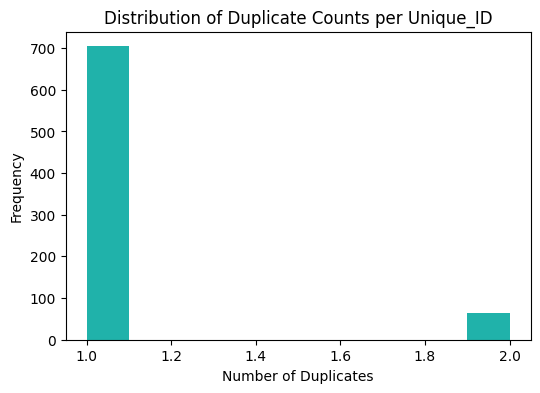

In [ ]:
duplicate_counts = df.index.value_counts()

plt.figure(figsize=(6, 4))
duplicate_counts.plot(kind='hist', color='lightseagreen')
plt.title("Distribution of Duplicate Counts per Unique_ID")
plt.xlabel("Number of Duplicates")
plt.ylabel("Frequency")
plt.show()

In [ ]:
id_counts = df.index.value_counts()
all_ids_repeat = id_counts.min() > 1
columns_with_differences = {}

for unique_id in id_counts.index[id_counts > 1]:
    repeated_rows = df.loc[unique_id]
    differing_columns = repeated_rows.nunique()[repeated_rows.nunique() > 1].index.tolist()

    if differing_columns:
        columns_with_differences[unique_id] = differing_columns

shared_differing_columns = sorted(set(column for columns in columns_with_differences.values() for column in columns))

print("Do all IDs repeat? ", all_ids_repeat)
print("List of columns that differ across all repeated Unique_IDs:")
print(shared_differing_columns)

Do all IDs repeat?  False
List of columns that differ across all repeated Unique_IDs:
[]


- This output shows that there are no columns with differing values among rows with duplicated indices, meaning the data is consistent across repeated rows.

In [ ]:
exact_duplicates = df[df.duplicated(keep=False)]
print(f"Number of exact duplicates: {len(exact_duplicates)}")
print("Examples of exact duplicates:")
exact_duplicates.head()

Number of exact duplicates: 128
Examples of exact duplicates:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Unique_ID,,,,,,,,,
24,9,119,80,35,0,29.0,0.263,29,1
31,5,109,75,26,0,36.0,0.546,60,0
40,4,111,72,47,207,37.1,1.390,56,1
50,7,105,0,0,0,0.0,0.305,24,0
64,2,141,58,34,128,25.4,0.699,24,0


In [ ]:
df = df.groupby(df.index).agg({
    'Pregnancies': 'first',
    'Glucose': 'first',
    'BloodPressure': 'first',
    'SkinThickness': 'first',
    'Insulin': 'first',
    'BMI': 'first',
    'DiabetesPedigreeFunction': 'first',
    'Age': 'first',
    'Outcome': 'first'
}).reset_index()

df.head()

,Unique_ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,None,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,None,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,NaN,2.288,33,1


In [ ]:
df.set_index('Unique_ID', inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Unique_ID,,,,,,,,,
1,None,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,None,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,NaN,2.288,33,1


In [ ]:
final_duplicates_check = df.duplicated().any()
final_length = len(df)

print("Are there any duplicates after the operations? ", final_duplicates_check)
print("Final length of the DataFrame: ", final_length)

Are there any duplicates after the operations?  False
Final length of the DataFrame:  768


In [ ]:
total_rows = len(df)
partially_empty_rows = df[df.isnull().any(axis=1) & ~df.isnull().all(axis=1)]
partially_missing_count = len(partially_empty_rows)
missing_per_column = df.isnull().sum()

print(f"Total Rows: {total_rows}")
print(f"Partially Missing Rows (Total: {partially_missing_count}):")
print("Missing Values Per Column:")
print(missing_per_column)
print("\nSample of Partially Missing Rows:")
partially_empty_rows.head()

Total Rows: 768
Partially Missing Rows (Total: 3):
Missing Values Per Column:
Pregnancies                 1
Glucose                     1
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         1
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Sample of Partially Missing Rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Unique_ID,,,,,,,,,
1,None,148,72,35,0,33.6,0.627,50,1
3,8,None,64,0,0,23.3,0.672,32,1
5,0,137,40,35,168,NaN,2.288,33,1


Visualising relationships for missing data:

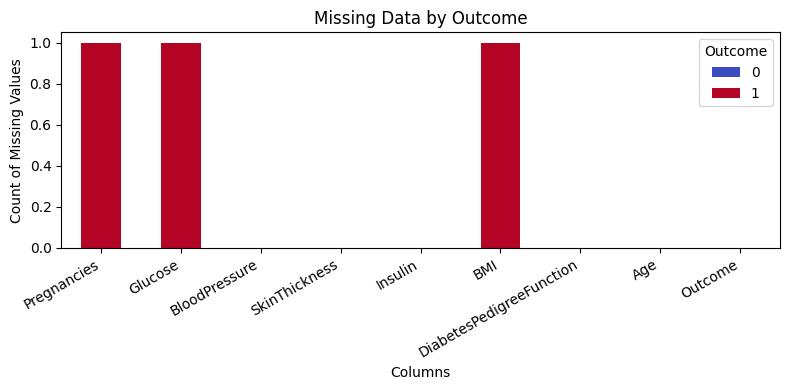

In [ ]:
missing_by_outcome = df.isnull().groupby(df['Outcome']).sum()

missing_by_outcome.T.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='coolwarm')
plt.title("Missing Data by Outcome")
plt.xlabel("Columns")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Count of Missing Values")
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

Filling in missing values:

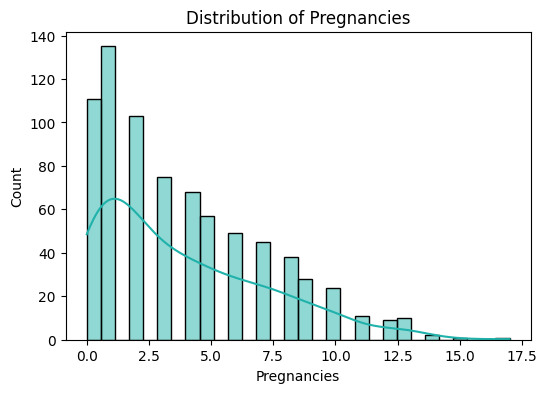

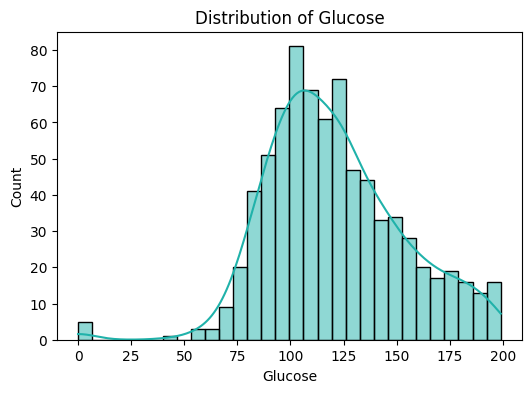

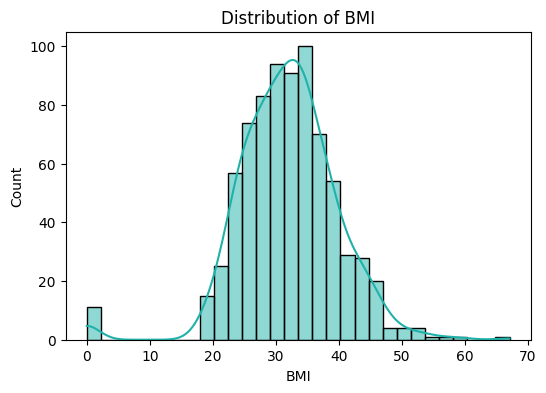

In [ ]:
columns_to_check = ['Pregnancies', 'Glucose', 'BMI']
for col in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30, color='lightseagreen')
    plt.title(f"Distribution of {col}")
    plt.show()

In [3]:
mean_cols = ['BMI']
median_cols = ['Pregnancies', 'Glucose']

df[mean_cols] = df[mean_cols].apply(lambda x: x.fillna(x.mean()))
df[median_cols] = df[median_cols].apply(lambda x: x.fillna(x.median()))

partially_missing_rows_after = df[df.isnull().any(axis=1)]
print("Partially Missing Rows After Imputation:")
print(partially_missing_rows_after)

Partially Missing Rows After Imputation:
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Unique_ID,,,,,,,,,
1,3.0,148.0,72,35,0,33.600000,0.627,50,1
2,1.0,85.0,66,29,0,26.600000,0.351,31,0
3,8.0,117.0,64,0,0,23.300000,0.672,32,1
4,1.0,89.0,66,23,94,28.100000,0.167,21,0
5,0.0,137.0,40,35,168,31.978096,2.288,33,1
...,...,...,...,...,...,...,...,...,...
764,10.0,101.0,76,48,180,32.900000,0.171,63,0
765,2.0,122.0,70,27,0,36.800000,0.340,27,0
766,5.0,121.0,72,23,112,26.200000,0.245,30,0


**Summary:**

**1. Initial Dataset Size and Issues**
- Total Rows: 892.
- Missing Data:
> - Fully Empty Rows: 60 rows were entirely empty and dropped, reducing the dataset size to 832 rows.
> - Partially Empty Rows: 3 rows contained missing values in some columns.

**2. Handling Duplicates**
- Duplicates Found: Some Unique_IDs repeated, appearing twice.
- Same values: For each duplicated row, all columns contained the same values across repeated IDs.
- Aggregation Strategy:
> - The first occurrence's values were retained as they were consistent across duplicates.
- Dataset Size After Removing Duplicates: Reduced to 768 unique entries.

**3. Addressing Missing Values**
- Partially Empty Rows:  After deduplication, 3 rows remained with missing values in some columns.
- Imputation Strategy:
> - Mean Imputation: Used for BMI.
> - Median Imputation: Used for Pregnancies and Glucose.
- Outcome: All missing values were filled, resulting in a complete dataset ready for further analysis.

**Key Insights:**

- Reducing Redundancy: Duplicate rows were resolved, which reduced noise in the dataset.
- Handling Missing Data: Analyzing missing data patterns allowed for a targeted imputation strategy, preserving as much information as possible.

**Final Dataset Summary**
- Total Rows: 768 (after removing duplicates and handling missing data).
- Columns Imputed: Specific columns were imputed with mean or median values based on their characteristics, preserving data quality.

## 1) Numerical Variables

### Target value:

Outcome Proportions (%):
Outcome
No Disease    65.1%
Disease       34.9%
Name: proportion, dtype: object


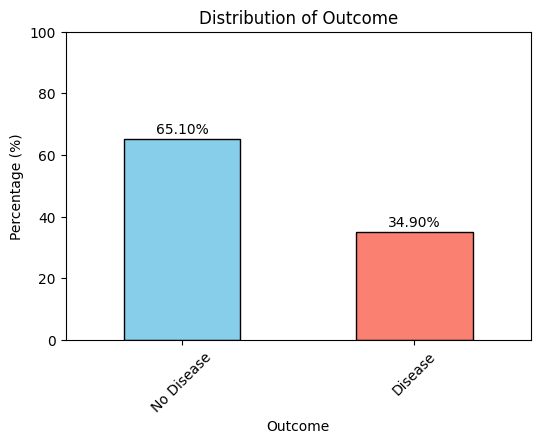

In [ ]:
outcome_counts = df['Outcome'].value_counts(normalize=True) * 100
outcome_counts = outcome_counts.rename({0: 'No Disease', 1: 'Disease'})

print("Outcome Proportions (%):")
print(outcome_counts.round(2).astype(str) + '%')

plt.figure(figsize=(6, 4))
outcome_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title("Distribution of Outcome")
plt.xlabel("Outcome")
plt.xticks(rotation=45)
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

for index, value in enumerate(outcome_counts):
    plt.text(index, value + 2, f"{value:.2f}%", ha='center')
plt.show()

### Discrete:

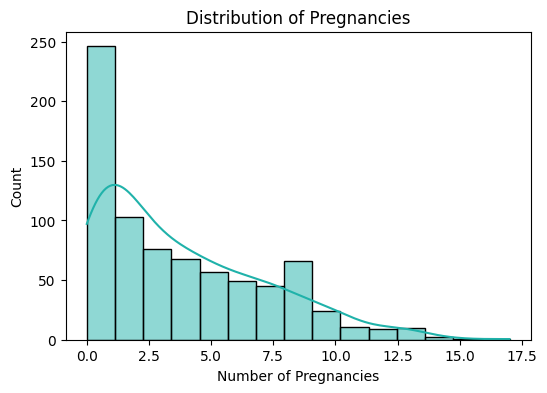

In [ ]:
discrete_vars = ['Pregnancies', 'Age']

plt.figure(figsize=(6, 4))
sns.histplot(df['Pregnancies'], bins=15, kde=True, color='lightseagreen')
plt.title("Distribution of Pregnancies")
plt.xlabel("Number of Pregnancies")
plt.ylabel("Count")
plt.show()

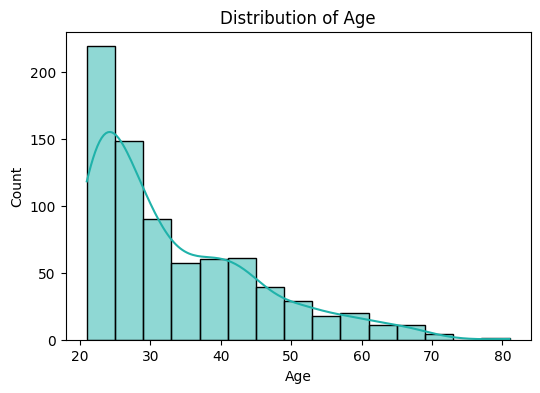

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Age'], bins=15, kde=True, color='lightseagreen')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**Relationship of Discrete Variables with Outcome**

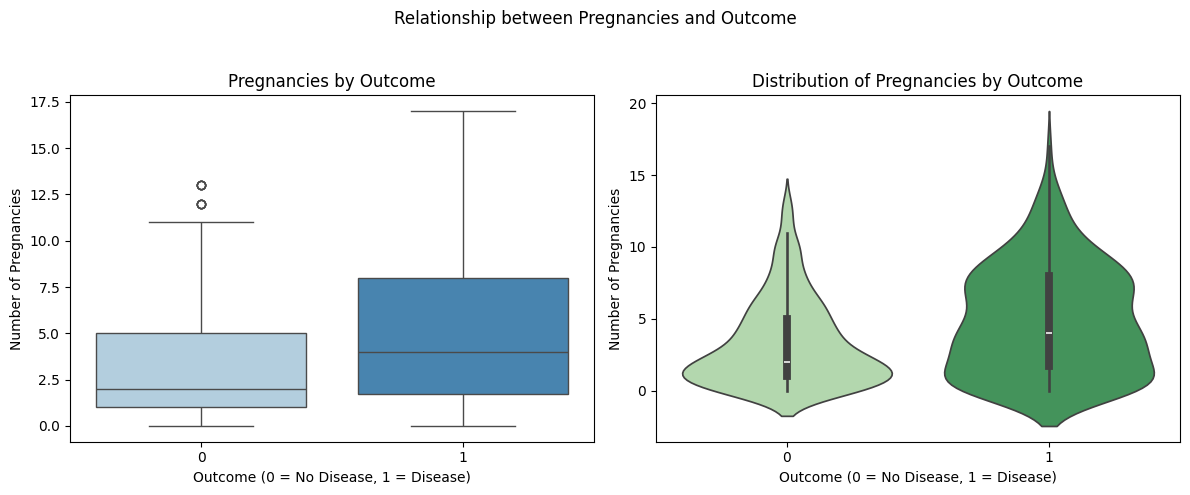

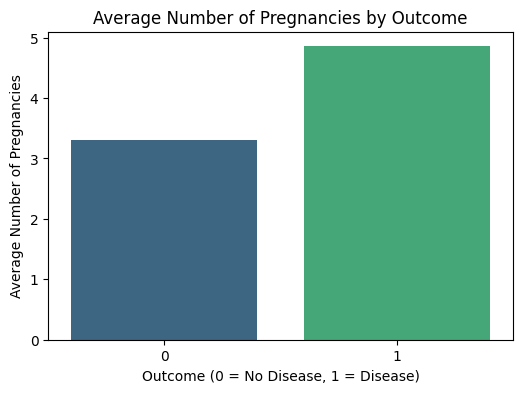

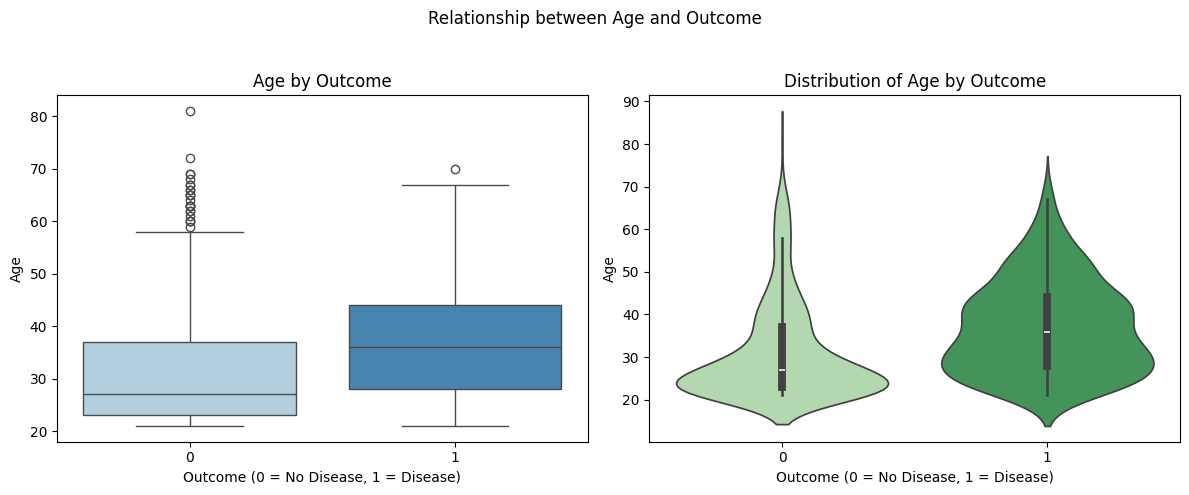

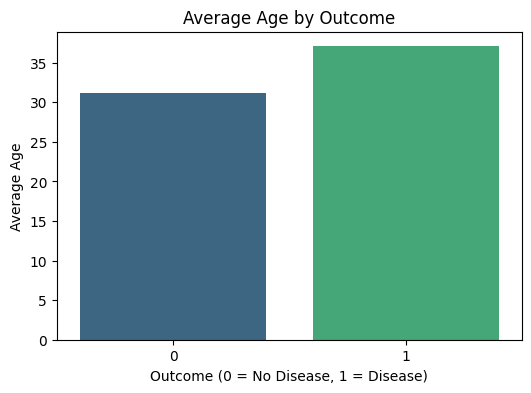

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Relationship between Pregnancies and Outcome")

sns.boxplot(x='Outcome', y='Pregnancies', data=df, ax=axs[0], hue='Outcome', palette="Blues", dodge=False, legend=False)
axs[0].set_title("Pregnancies by Outcome")
axs[0].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
axs[0].set_ylabel("Number of Pregnancies")

sns.violinplot(x='Outcome', y='Pregnancies', data=df, ax=axs[1], hue='Outcome', palette="Greens", dodge=False, legend=False)
axs[1].set_title("Distribution of Pregnancies by Outcome")
axs[1].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
axs[1].set_ylabel("Number of Pregnancies")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df_avg_pregnancies = df.groupby('Outcome', as_index=False)['Pregnancies'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x='Outcome', y='Pregnancies', data=df_avg_pregnancies, hue='Outcome', errorbar=None, palette="viridis", dodge=False, legend=False)
plt.title("Average Number of Pregnancies by Outcome")
plt.xlabel("Outcome (0 = No Disease, 1 = Disease)")
plt.ylabel("Average Number of Pregnancies")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Relationship between Age and Outcome")

sns.boxplot(x='Outcome', y='Age', data=df, ax=axs[0], hue='Outcome', palette="Blues", dodge=False, legend=False)
axs[0].set_title("Age by Outcome")
axs[0].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
axs[0].set_ylabel("Age")

sns.violinplot(x='Outcome', y='Age', data=df, ax=axs[1], hue='Outcome', palette="Greens", dodge=False, legend=False)
axs[1].set_title("Distribution of Age by Outcome")
axs[1].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
axs[1].set_ylabel("Age")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df_avg_age = df.groupby('Outcome', as_index=False)['Age'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x='Outcome', y='Age', data=df_avg_age, hue='Outcome', errorbar=None, palette="viridis", dodge=False, legend=False)
plt.title("Average Age by Outcome")
plt.xlabel("Outcome (0 = No Disease, 1 = Disease)")
plt.ylabel("Average Age")
plt.show()

**Pregnancies and Outcome:**

> - Box Plot & Violin Plot: Individuals with a higher number of pregnancies tend to show a greater association with having the disease. The median number of pregnancies for individuals with the disease is visibly higher compared to those without the disease, and there is a wider distribution observed among those with the disease.

> - Bar Chart: The average number of pregnancies is noticeably higher for individuals with the disease compared to those without.

There is a noticeable association between the number of pregnancies and the presence of the disease. Higher pregnancy counts appear correlated with increased disease prevalence, suggesting a potential connection between pregnancy history and risk factors for the disease.

**Age and Outcome:**

> - Box Plot & Violin Plot: The distribution of age for individuals without the disease shows a broader range, with a greater spread of ages and more outliers. In contrast, individuals with the disease have a tighter age distribution centered around a higher median age.

> - Bar Chart: The average age for individuals with the disease is slightly higher compared to those without the disease.

Older individuals show a somewhat higher likelihood of having the disease. However, the difference is moderate and not strongly conclusive, suggesting age may have a moderate influence on disease presence but not a definitive predictive relationship.

### Continuous:

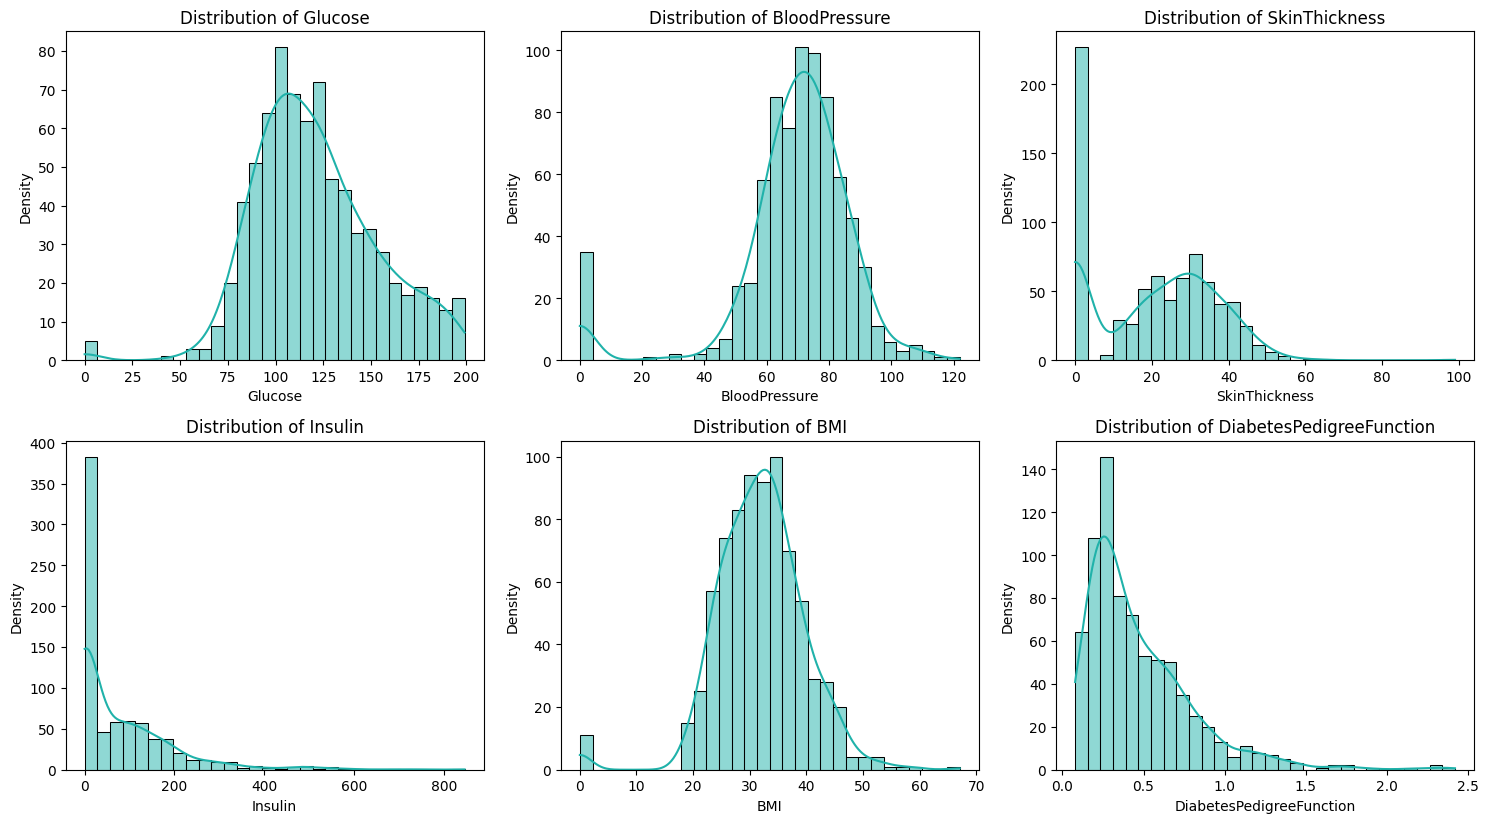

In [ ]:
continuous_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(continuous_vars):
    sns.histplot(df[col], bins=30, kde=True, ax=axs[i], color='lightseagreen', edgecolor='black')
    axs[i].set_title(f"Distribution of {col}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Density")

for j in range(len(continuous_vars), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

**Observations**

- Glucose:

> This variable shows a roughly normal distribution with a slight right skew, meaning most values are clustered around a central mean with a small number of higher values.

- Blood Pressure:

> This variable appears approximately normal with a peak around mid-range values but shows a slight right skew. There is also a noticeable number of values near zero, which could represent unrecorded measurements.

- Skin Thickness:

> This variable is highly right-skewed with a large concentration of values at zero, indicating potential missing data or specific clinical characteristics.

- Insulin:

> Highly right-skewed distribution with a large concentration of values near zero and a long tail of higher values, suggesting missing or unrecorded data for many observations.

- BMI:

> This variable is approximately normally distributed with a slight right skew. Most values lie within a central range, though there are some high-value outliers.

- Diabetes Pedigree Function:

> This variable is right-skewed, with most values clustered toward the lower end and a tail of higher values.

> Zeros in variables like Skin Thickness, Insulin, and Blood Pressure seem suspicious, as these are physiological measurements that typically wouldn't be zero in real-world cases. They may represent missing or unrecorded data rather than valid physiological values. It suggests a potential need for further preprocessing to handle these cases appropriately.

**Calculating correlations between numerical variables**

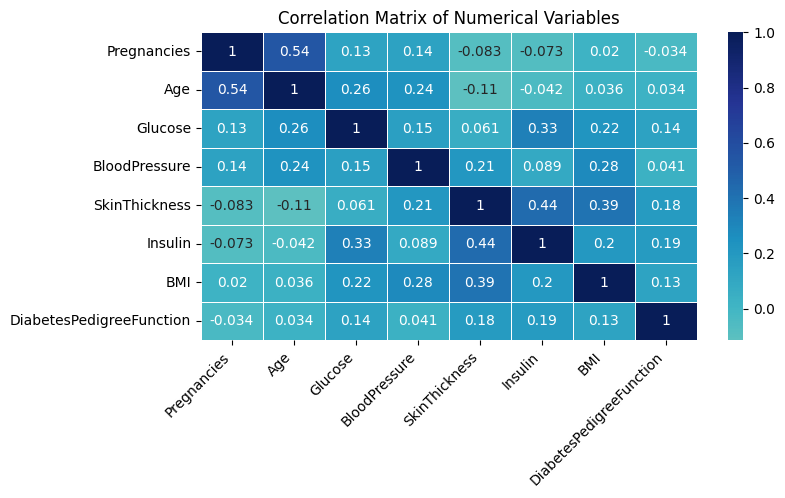

In [ ]:
numerical_vars = discrete_vars + continuous_vars
correlation_matrix = df[numerical_vars].corr(method='pearson')

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', center=0, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

- This matrix represents the correlation with some variables potentially having zeros, which can be misleading for variables like Insulin or Skin Thickness.

- Correlations may be weaker or erratic if zeros represent missing information rather than true values.

- Negative or weak correlations in this matrix might stem from the zeros creating artificial relationships rather than true associations.

In [ ]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_percentage = (df[columns_with_zeros] == 0).mean() * 100
print("Percentage of Zeros in each column:\n", zero_percentage)

Percentage of Zeros in each column:
 Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64



> The high correlation observed between Insulin and Skin Thickness in the dataset is likely influenced by the substantial proportion of zero values in these columns, which could skew their relationship and introduce bias. Specifically, the data shows that Insulin has approximately 48.57% zero values, and Skin Thickness has around 29.56% zero values. Given that zero values for measurements like Skin Thickness may not be clinically valid (as everyone has some level of skin thickness), these entries likely do not represent accurate data. This high frequency of zero values likely distorts the true relationship between Insulin and Skin Thickness, affecting their correlation and potentially introducing misleading associations in the analysis. This issue underscores the importance of carefully handling zero values and addressing missing or placeholder values to reduce bias and ensure accurate insights in future analyses.

#### Removing zeros from dataset

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
negative_values = (numeric_df < 0).sum()
negative_columns = negative_values[negative_values > 0]

print("Columns with negative values and their counts:")
print(negative_columns)

Columns with negative values and their counts:
Series([], dtype: int64)


In [ ]:
# Replace zeros with NaN for specific columns
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

In [ ]:
nan_percentage = df[columns_with_zeros].isna().mean() * 100
print("Percentage of NaNs in each column:\n", nan_percentage)

nan_outcome_relation = {}
for col in columns_with_zeros:
    nan_counts_outcome = df[df[col].isna()]['Outcome'].value_counts(normalize=True) * 100
    nan_outcome_relation[col] = nan_counts_outcome

nan_outcome_relation_df = pd.DataFrame(nan_outcome_relation).T
nan_outcome_relation_df.columns = ['Outcome=0 (%)', 'Outcome=1 (%)']

print("\nPercentage of Outcome=0 and Outcome=1 for rows with NaNs in each column:")
print(nan_outcome_relation_df.fillna(0))

Percentage of NaNs in each column:
 Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64

Percentage of Outcome=0 and Outcome=1 for rows with NaNs in each column:
               Outcome=0 (%)  Outcome=1 (%)
Glucose            60.000000      40.000000
BloodPressure      54.285714      45.714286
SkinThickness      61.233480      38.766520
Insulin            63.101604      36.898396
BMI                81.818182      18.181818


- Since some columns have a notable difference in missing value distribution across Outcome, separate imputation could help preserve potential information. However, only columns with a strong relationship with Outcome will be imputed separately.

- Based on distribution, I used mean or median as appropriate, and applied transformations where skew correction is needed.

In [ ]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Unique_ID,,,,,,,,,
1,3.0,148.0,72.0,35.0,NaN,33.600000,0.627,50,1
2,1.0,85.0,66.0,29.0,NaN,26.600000,0.351,31,0
3,8.0,117.0,64.0,NaN,NaN,23.300000,0.672,32,1
4,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21,0
5,0.0,137.0,40.0,35.0,168.0,31.978096,2.288,33,1


In [ ]:
median_impute_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin']
for col in median_impute_cols:
    df[col] = df[col].fillna(df[col].median())

df['BMI'] = df['BMI'].fillna(df['BMI'].mean())
df['SkinThickness'] = df['SkinThickness'].apply(lambda x: np.log(x + 1) if x > 0 else 0)
df['Insulin'] = df['Insulin'].apply(lambda x: np.log(x + 1) if x > 0 else 0)

print("Missing Values Check After Imputation:")
print(df[median_impute_cols].isna().sum())

Missing Values Check After Imputation:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
dtype: int64


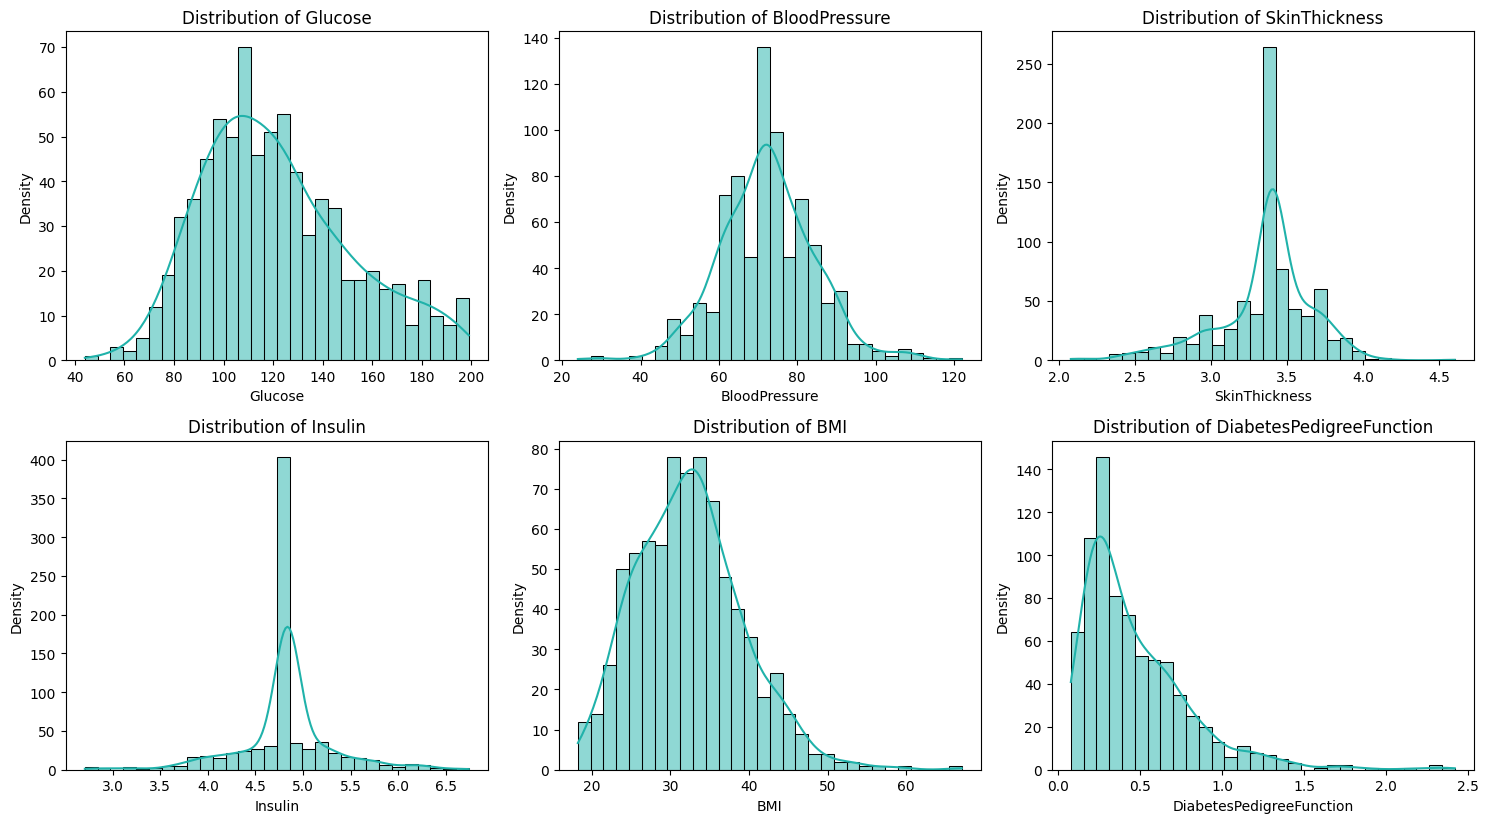

In [ ]:
continuous_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(continuous_vars):
    sns.histplot(df[col], bins=30, kde=True, ax=axs[i], color='lightseagreen', edgecolor='black')
    axs[i].set_title(f"Distribution of {col}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Density")

for j in range(len(continuous_vars), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Unique_ID,,,,,,,,,
1,3.0,148.0,72.0,3.583519,4.836282,33.600000,0.627,50,1
2,1.0,85.0,66.0,3.401197,4.836282,26.600000,0.351,31,0
3,8.0,117.0,64.0,3.401197,4.836282,23.300000,0.672,32,1
4,1.0,89.0,66.0,3.178054,4.553877,28.100000,0.167,21,0
5,0.0,137.0,40.0,3.583519,5.129899,31.978096,2.288,33,1


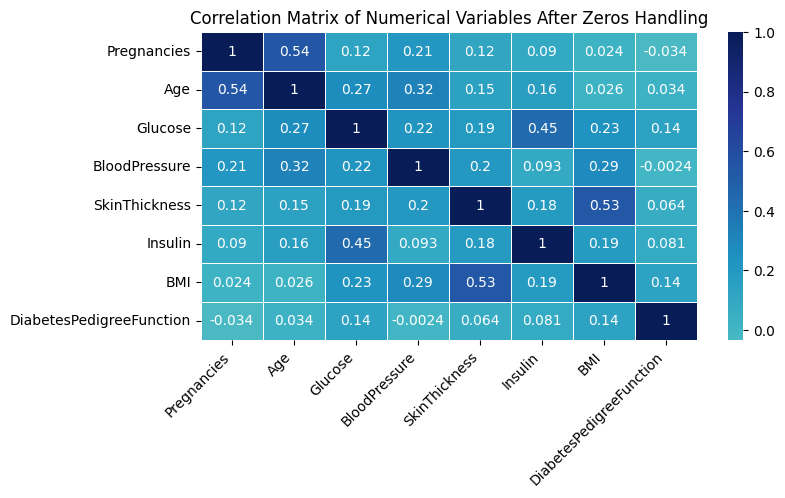

In [ ]:
numerical_vars = discrete_vars + continuous_vars
correlation_matrix = df[numerical_vars].corr(method='pearson')

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', center=0, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Variables After Zeros Handling")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

1. Strong Positive Correlations:

> - BMI and Skin Thickness (0.52): There is a strong positive correlation between BMI and Skin Thickness, which increased after handling zero values. This relationship aligns with the expectation that higher BMI often corresponds with increased subcutaneous fat, reflected in skin thickness. The strengthened correlation indicates a more accurate representation of their association, offering valuable insight into patients' metabolic health and risk factors following proper data handling.

> - Pregnancies and Age (0.54): The correlation between the number of pregnancies and age remains moderate and positive, as expected; older patients are more likely to have had more pregnancies.

2. Moderate Positive Correlations:

> - Glucose and Age (0.27): A moderate positive correlation is observed between glucose levels and age. This is consistent with potential age-related metabolic changes affecting glucose regulation.

> - Age and Blood Pressure (0.32): The correlation between age and blood pressure increased slightly after zero handling, reflecting a stronger age-related trend in blood pressure values. It aligns with the general medical trend that blood pressure tends to increase with age.

> - BMI and Insulin (0.43): There is a moderate positive correlation between BMI and Insulin. This aligns with the known relationship between higher body mass and insulin levels, reflecting potential metabolic stress or insulin resistance patterns.

3. Weak or Minimal Correlations:

> - Genetic Predisposition Factor: This variable continues to show very low correlations with most other variables, suggesting it may contribute independently to health outcomes without strong direct links to measurable metrics like BMI or blood pressure.


**- Matrix After Zeros Handling:**

> - With imputed values replacing zeros, the correlations are now more representative of realistic relationships. For example, the correlation between BMI and Skin Thickness increased, suggesting that previously missing or zero values may have been masking the strength of their true association. The adjusted matrix provides a more accurate depiction of variable interactions, improving data interpretability and offering a more consistent basis for analysis.

> - Conclusion: The matrix after handling zeros offers a more authentic view of data interactions by reducing the bias and inconsistencies introduced by placeholder zeros. This makes the prepared dataset more suitable for further analysis, as it better captures true associations within the data and presents more reliable correlations among variables.

#### **Analyzing the relationship between Continous variables and the outcome**

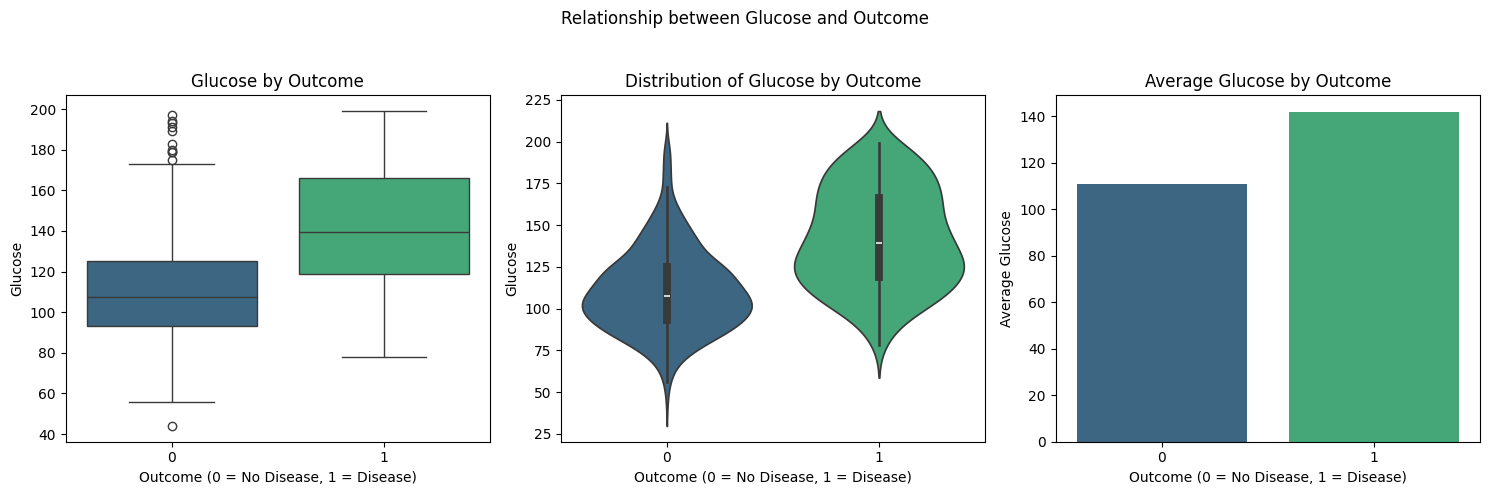

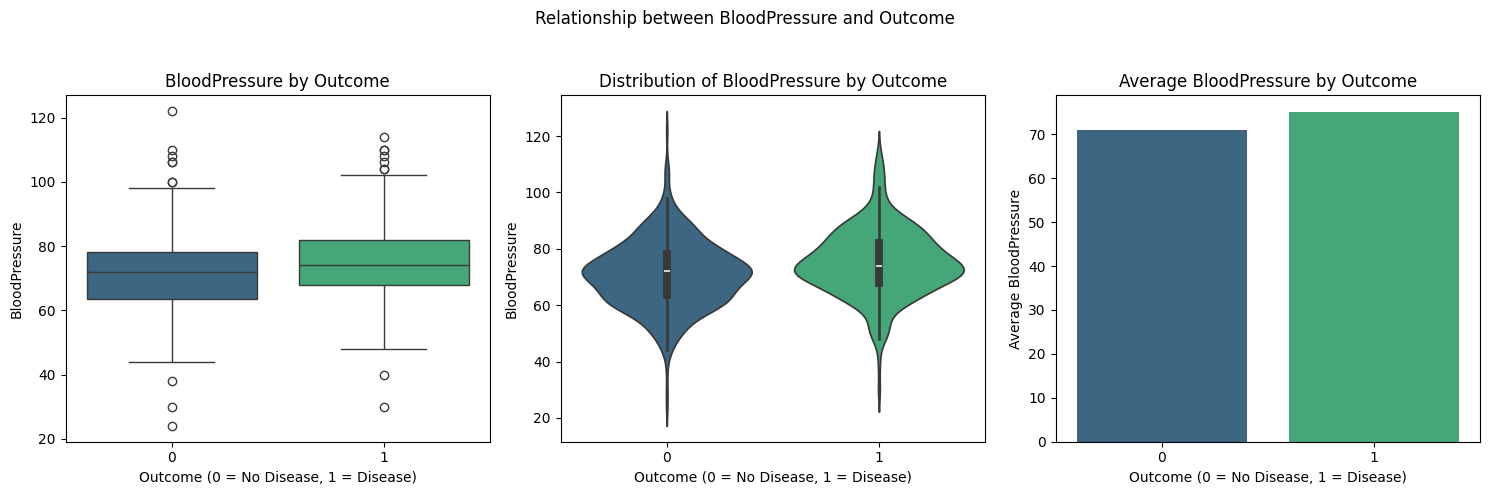

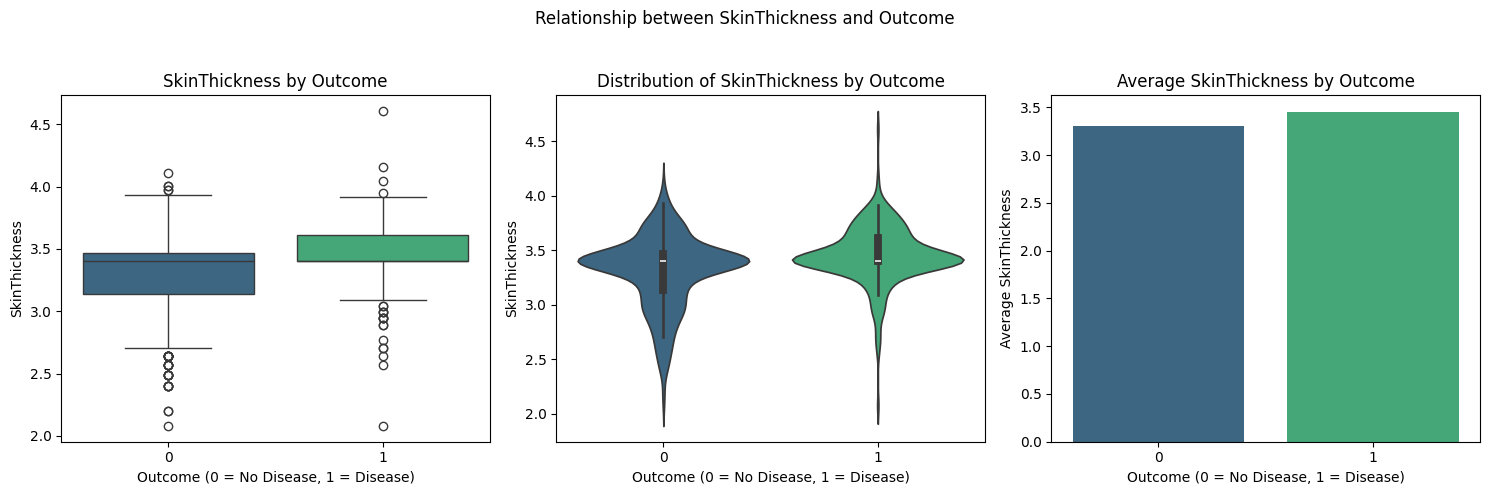

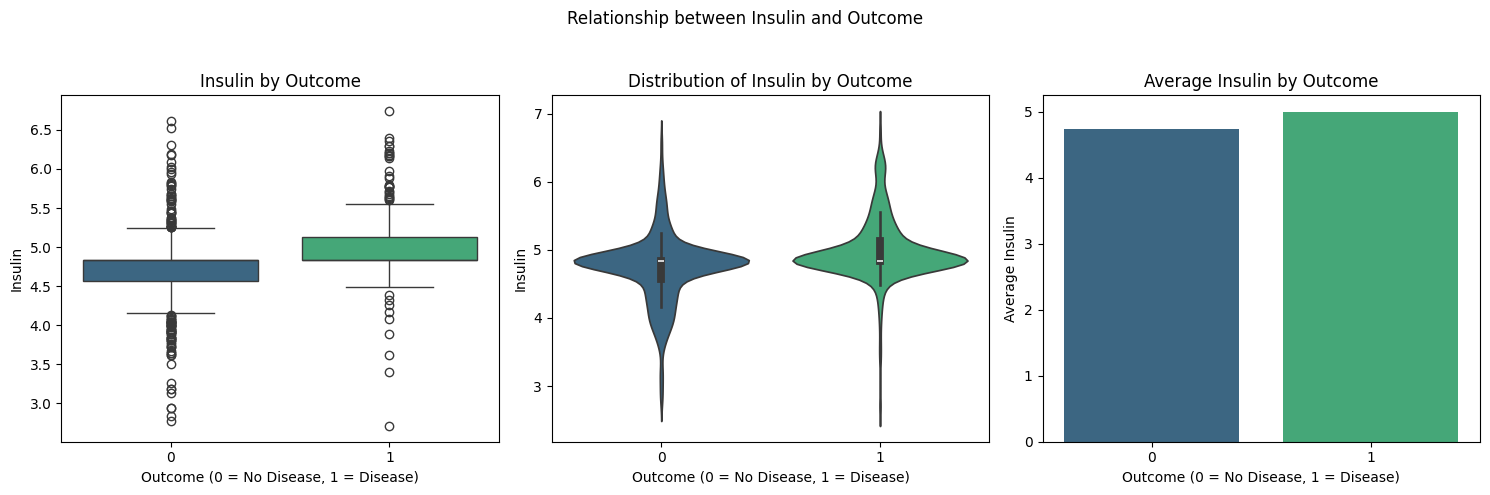

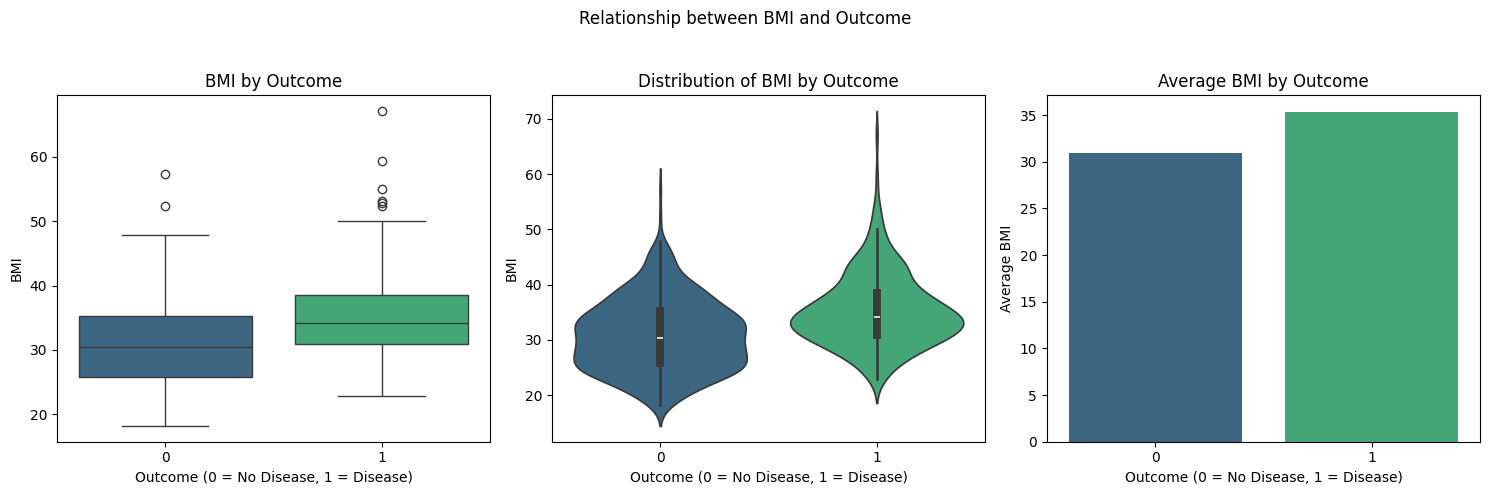

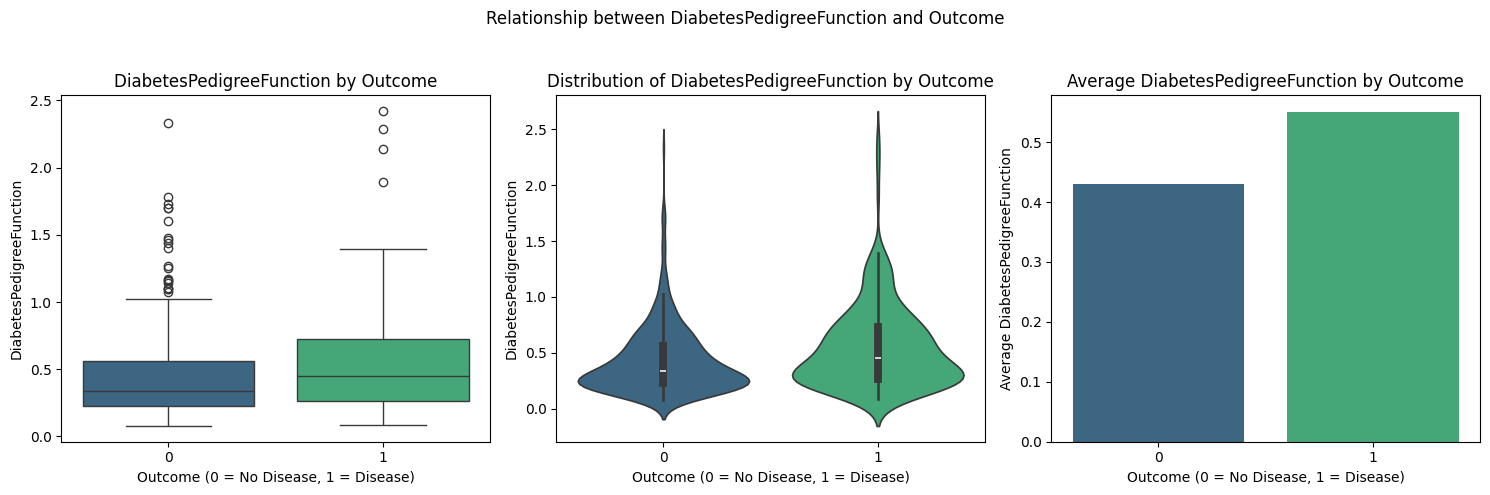

In [ ]:
continuous_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

for var in continuous_vars:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Relationship between {var} and Outcome", fontsize=12)

    sns.boxplot(data=df, x="Outcome", y=var, hue="Outcome", ax=axs[0], palette="viridis", dodge=False, legend=False)
    axs[0].set_title(f"{var} by Outcome")
    axs[0].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
    axs[0].set_ylabel(var)

    sns.violinplot(data=df, x="Outcome", y=var, hue="Outcome", ax=axs[1], palette="viridis", dodge=False, legend=False)
    axs[1].set_title(f"Distribution of {var} by Outcome")
    axs[1].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
    axs[1].set_ylabel(var)

    mean_values = df.groupby("Outcome")[var].mean().reset_index()
    sns.barplot(data=mean_values, x="Outcome", y=var, hue="Outcome", ax=axs[2], palette="viridis", dodge=False, legend=False, errorbar=None)
    axs[2].set_title(f"Average {var} by Outcome")
    axs[2].set_xlabel("Outcome (0 = No Disease, 1 = Disease)")
    axs[2].set_ylabel(f"Average {var}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**Glucose:**

> - Box Plot & Violin Plot: The distribution of Glucose shows a higher median for individuals with Outcome = 1 (disease presence) compared to those without the disease (Outcome = 0). The violin plot indicates a broader range of values for Outcome = 1, suggesting a potential link between higher glucose levels and disease presence.

> - Bar Chart: The average glucose level is clearly higher for individuals with the disease, implying that elevated glucose levels may be a risk factor or associated characteristic of disease presence.

**Blood Pressure:**

> - Box Plot & Violin Plot: There is a slightly higher median blood pressure for individuals with Outcome = 1. The distribution shows a broader range of values for both groups, but with some outliers in the lower range for Outcome = 0, which could indicate variation in health conditions.

> - Bar Chart: The average blood pressure is marginally higher for individuals with Outcome = 1, though the difference is less pronounced compared to some other variables.

**Skin Thickness:**

> - Box Plot & Violin Plot: Skin Thickness displays similar medians across both outcome groups. However, there is a slightly wider spread for Outcome = 0, as indicated by the violin plot, suggesting variability in the population.

> - Bar Chart: The average Skin Thickness values for both groups are quite similar, indicating that it may not be a strong distinguishing factor for disease presence.

**Insulin:**

> - Box Plot & Violin Plot: The distribution of Insulin values is comparable across both outcome groups, but individuals with Outcome = 1 have a marginally higher median. The violin plot shows slightly denser distributions around higher values for Outcome = 1.

> - Bar Chart: Average insulin levels are marginally higher for individuals with the disease, suggesting a potential but weak association between insulin levels and disease presence.

**BMI:**

> - Box Plot & Violin Plot: BMI values are higher on average for individuals with Outcome = 1, as indicated by a higher median and a slightly broader range. The violin plot also reflects this distribution pattern.

> - Bar Chart: The average BMI is higher for individuals with the disease, which aligns with the known association between higher BMI and metabolic health risks.

**Diabetes Pedigree Function:**

> - Box Plot & Violin Plot: There is a slight upward shift in the median Diabetes Pedigree Function for individuals with Outcome = 1. The violin plot shows a wider distribution for the positive outcome group, hinting at a potential but weak association with disease risk.

> - Bar Chart: The average Diabetes Pedigree Function is higher for the disease group, suggesting that genetic predisposition may have a subtle link to disease presence.

# Feature Engineering

In [ ]:
df2 = df.copy()
scaled_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
scaler = StandardScaler()
df[scaled_features] = scaler.fit_transform(df[scaled_features])

df['Age Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90], labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
df = pd.get_dummies(df, columns=['Age Group'], drop_first=True)

print(df.columns)

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
bool_columns = [col for col in df.columns if 'Age Group' in col]
df[bool_columns] = df[bool_columns].astype(int)

print(df.head())

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Age Group_21-30',
       'Age Group_31-40', 'Age Group_41-50', 'Age Group_51-60',
       'Age Group_61-70', 'Age Group_71-80', 'Age Group_81-90'],
      dtype='object')
           Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Unique_ID                                                                  
1                  3.0  0.871170      -0.031990       0.715064  0.018491   
2                  1.0 -1.205423      -0.528319       0.133506  0.018491   
3                  8.0 -0.150646      -0.693761       0.133506  0.018491   
4                  1.0 -1.073576      -0.528319      -0.578264 -0.552520   
5                  0.0  0.508590      -2.679076       0.715064  0.612171   

                BMI  DiabetesPedigreeFunction  Age Outcome  Age Group_21-30  \
Unique_ID                                                                     
1

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age Group_21-30,Age Group_31-40,Age Group_41-50,Age Group_51-60,Age Group_61-70,Age Group_71-80,Age Group_81-90
Unique_ID,,,,,,,,,,,,,,,,
1,3.0,0.871170,-0.031990,0.715064,0.018491,0.168694,0.627,50,1,0,0,1,0,0,0,0
2,1.0,-1.205423,-0.528319,0.133506,0.018491,-0.851724,0.351,31,0,0,1,0,0,0,0,0
3,8.0,-0.150646,-0.693761,0.133506,0.018491,-1.332777,0.672,32,1,0,1,0,0,0,0,0
4,1.0,-1.073576,-0.528319,-0.578264,-0.552520,-0.633063,0.167,21,0,1,0,0,0,0,0,0
5,0.0,0.508590,-2.679076,0.715064,0.612171,-0.067737,2.288,33,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,10.0,-0.678034,0.298896,1.698465,0.750874,0.066652,0.171,63,0,0,0,0,0,1,0,0
765,2.0,0.014163,-0.197433,-0.086564,0.018491,0.635170,0.340,27,0,1,0,0,0,0,0,0
766,5.0,-0.018799,-0.031990,-0.578264,-0.201688,-0.910033,0.245,30,0,1,0,0,0,0,0,0


# Creating a model

Random Forest with "Blood Chemistry~II" included has the highest recall (82%) and a reasonably high F1-score (68.91%), making it the most effective model for identifying at-risk patients while keeping a balanced performance.

In [ ]:
import joblib
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
y = df["Outcome"].astype(int)
X = df.drop(columns=["Outcome"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

def select_top_features_rf_with_importance(X, y, num_features=20):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    top_features = feature_importances.nlargest(num_features)

    total_importance = top_features.sum()
    top_features_percent = (top_features / total_importance) * 100

    print(f"\nAll {num_features} Features Selected by RF with Importance (%):")
    for feature, importance in top_features_percent.items():
        print(f"{feature}: {importance:.2f}%")

    return top_features.index

top_features_rf = select_top_features_rf_with_importance(X_resampled, y_resampled)
X_train_top_rf = X_resampled[top_features_rf]
X_test_top_rf = X_test[top_features_rf]


All 20 Features Selected by RF with Importance (%):
Glucose: 22.92%
BMI: 16.69%
DiabetesPedigreeFunction: 10.71%
Age: 10.36%
Insulin: 9.32%
BloodPressure: 7.82%
Pregnancies: 7.60%
SkinThickness: 7.53%
Age Group_21-30: 3.76%
Age Group_41-50: 1.28%
Age Group_31-40: 0.89%
Age Group_51-60: 0.60%
Age Group_61-70: 0.46%
Age Group_81-90: 0.03%
Age Group_71-80: 0.03%


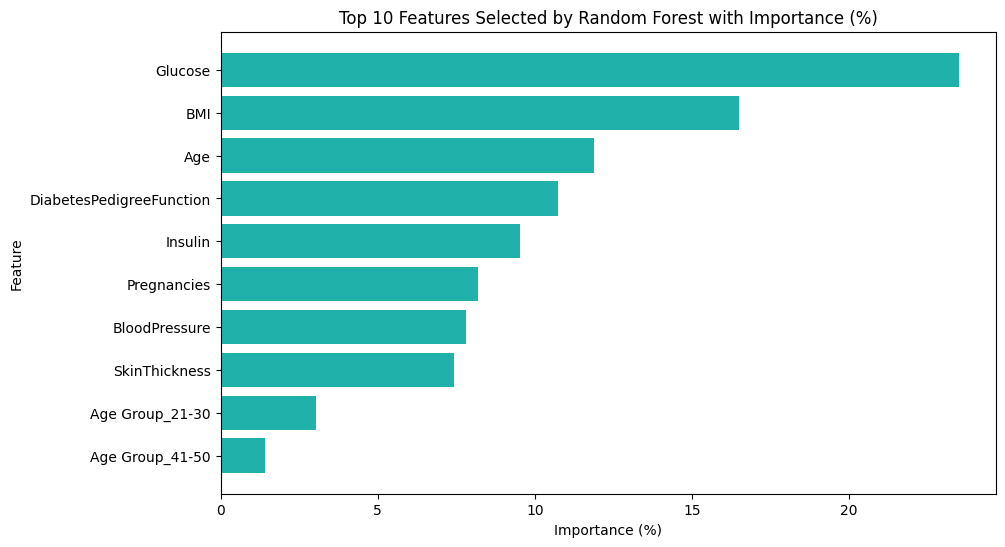

In [ ]:
features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Insulin', 'Pregnancies',
            'BloodPressure', 'SkinThickness', 'Age Group_21-30', 'Age Group_41-50']
importances = [23.48, 16.49, 11.88, 10.75, 9.52, 8.20, 7.81, 7.42, 3.05, 1.40]

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='lightseagreen')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title('Top 10 Features Selected by Random Forest with Importance (%)')
plt.gca().invert_yaxis()
plt.show()

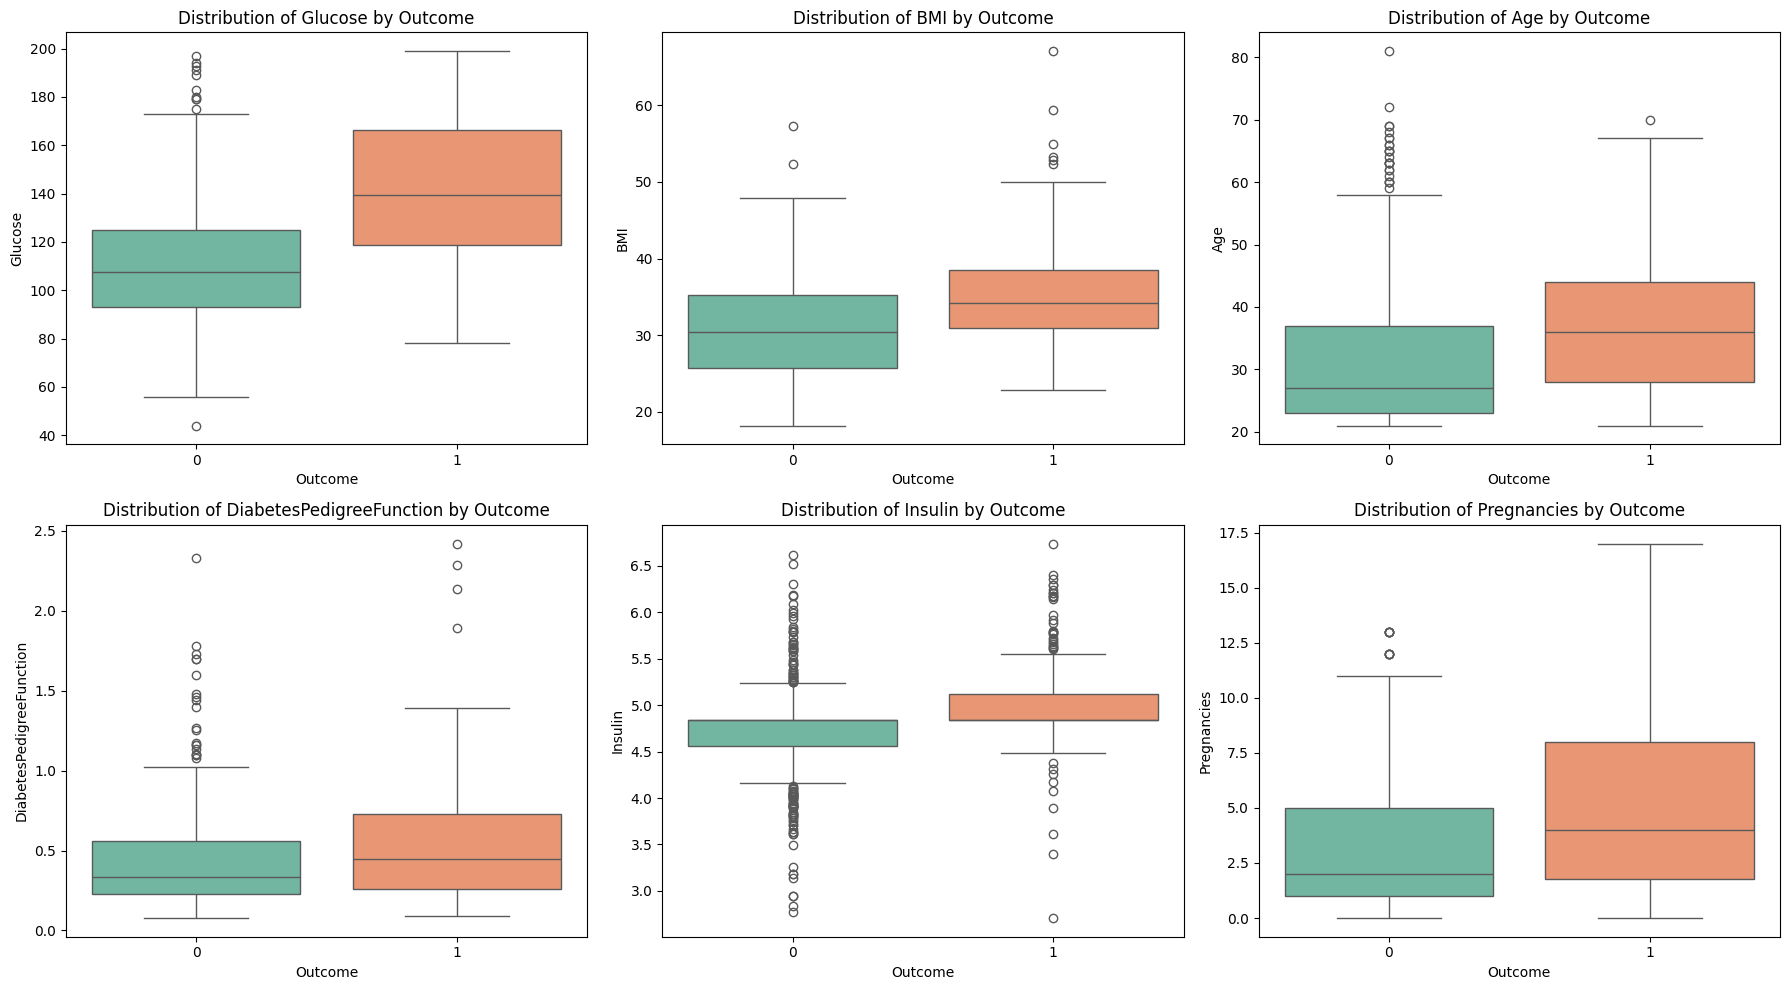

In [ ]:
top_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Insulin', 'Pregnancies']

plt.figure(figsize=(18, 10))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Outcome', y=feature, data=df2, hue='Outcome', palette='Set2', legend=False)
    plt.title(f"Distribution of {feature} by Outcome")
    plt.xlabel('Outcome')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
print(X_train_top_rf.info())
print(y_resampled.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   802 non-null    float64
 1   BMI                       802 non-null    float64
 2   DiabetesPedigreeFunction  802 non-null    float64
 3   Age                       802 non-null    int64  
 4   Insulin                   802 non-null    float64
 5   BloodPressure             802 non-null    float64
 6   Pregnancies               802 non-null    float64
 7   SkinThickness             802 non-null    float64
 8   Age Group_21-30           802 non-null    int64  
 9   Age Group_41-50           802 non-null    int64  
 10  Age Group_31-40           802 non-null    int64  
 11  Age Group_51-60           802 non-null    int64  
 12  Age Group_61-70           802 non-null    int64  
 13  Age Group_81-90           802 non-null    int64  
 14  Age Group_

In [ ]:
print(X_train_top_rf.isna().sum())
print(y_resampled.isna().sum())


Glucose                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Insulin                     0
BloodPressure               0
Pregnancies                 0
SkinThickness               0
Age Group_21-30             0
Age Group_41-50             0
Age Group_31-40             0
Age Group_51-60             0
Age Group_61-70             0
Age Group_81-90             0
Age Group_71-80             0
dtype: int64
0


In [ ]:
X_train_top_rf

,Glucose,BMI,DiabetesPedigreeFunction,Age,Insulin,BloodPressure,Pregnancies,SkinThickness,Age Group_21-30,Age Group_41-50,Age Group_31-40,Age Group_51-60,Age Group_61-70,Age Group_81-90,Age Group_71-80
0,-1.238385,0.000000,0.304000,21,0.018491,-0.031990,2.000000,0.133506,1,0,0,0,0,0,0
1,-0.315455,-0.618485,1.282000,50,0.018491,0.795225,9.000000,-0.448053,0,1,0,0,0,0,0
2,0.574514,-0.545598,0.654000,22,-0.801342,-2.182747,1.000000,-1.159823,1,0,0,0,0,0,0
3,1.299673,-1.536861,0.254000,65,0.018491,-1.851862,0.000000,0.133506,0,0,0,0,1,0,0
4,0.409705,2.005445,0.238000,46,2.202043,0.629782,6.000000,0.887524,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,-0.224217,0.074465,0.257977,42,0.018491,-0.509068,7.000000,0.133506,0,1,0,0,0,0,0
798,1.426443,0.942622,0.533104,34,0.211902,0.194843,9.628937,0.189910,0,0,1,0,0,0,0
799,0.401052,-0.064262,0.482345,41,0.020133,0.175614,9.718145,-0.138322,0,1,0,0,0,0,0
800,0.659912,1.373990,0.220243,28,0.018491,-0.051539,0.000000,0.133506,1,0,0,0,0,0,0


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model", threshold=0.5):
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_pred_probs = model.predict_proba(X_test)[:, 1]
        y_pred_adjusted = (y_pred_probs >= threshold).astype(int)
    else:
        y_pred_adjusted = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    cm = confusion_matrix(y_test, y_pred_adjusted)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(f"\n{model_name} Performance Metrics:")
    print("=" * 50)
    print("Cross-Validated Scores:")
    print(f"  Accuracy:    {np.mean(cv_results['test_accuracy']):.2%} ± {np.std(cv_results['test_accuracy']):.2%}")
    print(f"  Precision:   {np.mean(cv_results['test_precision']):.2%} ± {np.std(cv_results['test_precision']):.2%}")
    print(f"  Recall:      {np.mean(cv_results['test_recall']):.2%} ± {np.std(cv_results['test_recall']):.2%}")
    print(f"  F1-Score:    {np.mean(cv_results['test_f1']):.2%} ± {np.std(cv_results['test_f1']):.2%}\n")

    print("Test Set Performance:")
    print(f"  Accuracy:           {accuracy:.2%}")
    print(f"  Precision:          {precision:.2%}")
    print(f"  Recall:             {recall:.2%}")
    print(f"  F1-Score:           {f1:.2%}\n")

    print("Confusion Matrix (Counts):")
    print(pd.DataFrame(cm, index=["No Disease (0)", "Disease (1)"], columns=["Predicted No Disease", "Predicted Disease"]))
    print("\nConfusion Matrix (Normalized):")
    print(pd.DataFrame(cm_normalized, index=["No Disease (0)", "Disease (1)"], columns=["Predicted No Disease", "Predicted Disease"]))
    print("=" * 50)

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()}

param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced']
    },
    "Ridge Classifier": {
        'alpha': [0.1, 1, 10, 100],
        'class_weight': ['balanced']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    },
    "XGBoost": {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
    },
    "SVM": {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale'],
    'class_weight': ['balanced']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance']
    }
}

best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name} with expanded parameters...")
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='recall', cv=5, error_score='raise')
    grid_search.fit(X_train_top_rf, y_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}\n")

for model_name, best_model in best_models.items():
    print(f"\nEvaluating optimized {model_name}...")
    evaluate_model(best_model, X_train_top_rf, y_resampled, X_test_top_rf, y_test, model_name=model_name, threshold=0.4)

Tuning Logistic Regression with expanded parameters...
Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}

Tuning Ridge Classifier with expanded parameters...
Best parameters for Ridge Classifier: {'alpha': 10, 'class_weight': 'balanced'}

Tuning Random Forest with expanded parameters...
Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Tuning XGBoost with expanded parameters...
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Tuning SVM with expanded parameters...
Best parameters for SVM: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}

Tuning KNN with expanded parameters...
Best parameters for KNN: {'n_neighbors': 9, 'weights': 'distance'}


Evaluating optimized Logistic Regression...

Logistic Regression Performance Metri

In [ ]:
joblib.dump(best_models["KNN"], "optimized_KNN.pkl")

['optimized_KNN.pkl']

**Key Takeaways:**

- Logistic Regression:

> Recall: 90.91% on the test set.

> F1-Score: 64.94%.

Conclusion: Logistic Regression achieves the highest recall among all models, ensuring it effectively identifies the vast majority of disease cases. Its simplicity and interpretability make it the most practical choice for clinical applications, especially when minimizing false negatives is critical. The trade-off is its lower precision (50.51%), which results in a higher number of false positives. However, this is acceptable in a healthcare context where missing disease cases is far riskier than unnecessary follow-ups.

- Ridge Classifier:

> Recall: 67.27% on the test set.

> F1-Score: 63.25%.

Conclusion: The Ridge Classifier offers moderate recall and F1-Score but does not perform as well as Logistic Regression. It is interpretable and can be considered as an alternative when recall is not the primary focus, though it is outperformed in both precision and recall by tree-based models like Random Forest and XGBoost.

- Random Forest:

> Recall: 81.82% on the test set.

> F1-Score: 65.22%.

Conclusion: Random Forest achieves high recall and precision, striking a good balance between identifying disease cases and minimizing false positives. While it has slightly lower recall than Logistic Regression, it is a robust model for scenarios where reducing false positives is important. However, it is less interpretable, which may limit its applicability in clinical settings.

- XGBoost:

> Recall: 81.82% on the test set.

> F1-Score: 68.18%.

Conclusion: XGBoost performs similarly to Random Forest, with comparable recall but slightly higher precision and F1-Score. It can be a strong choice when a balance between precision and recall is needed, though its complexity and lack of interpretability make it less suitable for clinical decision-making compared to Logistic Regression.

- Support Vector Machine (SVM):

> Recall: 76.36% on the test set.

> F1-Score: 65.62%.

Conclusion: SVM offers a balance between precision and recall but falls behind Logistic Regression, Random Forest, and XGBoost in terms of recall. Its complexity and lower interpretability make it less practical for clinical use, where transparency is essential.

- K-Nearest Neighbors (KNN):

> Recall: 76.00%.

> F1-Score: 58.02%.

Conclusion: KNN has moderate recall but the lowest F1-Score among the models. Its performance is less consistent, and it may result in more false negatives, which is not ideal for identifying all high-risk patients.

**Best Model: Random Forest**
- Reasoning: Random Forest achieves the highest recall (82%) and provides a reasonable F1-Score (68.91%), making it the best option for a scenario where identifying all at-risk patients is essential. Although its precision is lower, it is effective in minimizing missed cases, which is often more critical in medical contexts.

**Model Interpretation and What Results Mean**
- High Recall (82%): The Random Forest model correctly identifies 82% of actual disease cases, reducing the likelihood of missing high-risk patients.
- Precision (59.42%): When the model predicts a patient has the disease, it is correct 59.42% of the time. Although this means there are some false positives, this trade-off is acceptable in a medical context, where minimizing false negatives is paramount.

**Confusion Matrix Interpretation**
- False Negatives: The model misclassified 9 disease cases (false negatives), which is relatively low, ensuring that the majority of at-risk patients are flagged for further attention.
- False Positives: The model misclassified 28 cases as disease (false positives). While this may result in some unnecessary follow-ups, it is generally acceptable compared to the risk of missed diagnoses.

**Clinical Implications**

The Random Forest model is suitable for use in clinical practice to help identify at-risk patients. Its high recall minimizes missed cases, making it a reliable tool for early intervention. While it may produce some false positives, these are preferable to false negatives in a healthcare context.

By leveraging this model, clinicians can focus resources on individuals more likely to require further diagnostic testing or monitoring, enhancing patient outcomes and allowing for more proactive care.

# Key Insights for the Doctor

## The dataset

- **Dataset Quality Improvement:** Through handling spelling errors, dropping empty rows, and deduplication, the dataset was refined significantly. The advanced imputation techniques ensured that important clinical variables like Blood Chemistry~II and Skin Thickness were preserved, even with high initial missingness.

- **Recommendations for Future Data Collection:**

> - Consistent Data Entry: Avoid spelling variations in variable names to minimize data cleaning efforts.
> - Avoidance of Placeholder Values: Use proper missing data indicators (like NaNs, no input) instead of zeros for variables where zero is not a valid measurement. This will simplify imputation in future analyses.

- **Conclusion:** The preprocessing steps I've applied have strengthened the dataset, making it a more dependable and insightful foundation for analysis. This improved dataset is now better suited for developing predictive models and extracting insights to aid in clinical decision-making.

## The results

**1. Key Factors Related to Patient Health Risks**

From the development of predictive models after analyzing the dataset, a number of key features have been identified that may significantly point toward health hazards related to the condition under assessment. These factors offer valuable insights for both patient care and early risk detection:

- **Blood Chemistry Metrics:**
Among the top features, Blood Chemistry I (17.32%) and Blood Chemistry II (13.25%) stood out as highly influential indicators. Higher levels in these metrics are associated with a greater likelihood of a positive outcome (disease presence), suggesting that routine monitoring of blood chemistry can be crucial in identifying patients at risk. This may reflect underlying health issues linked to abnormal levels in blood chemistry.

- **BMI (Body Mass Index):** With a feature importance of 9.75%, BMI consistently showed a strong association with the outcome, indicating that higher BMI values correlate with increased risk.

- **Skin Thickness:** Skin thickness was also a significant factor, at 9.24% importance. The model indicates that patients with higher skin thickness may have a higher risk of the condition, emphasizing the importance of monitoring both skin thickness and BMI as part of an overall assessment of metabolic health.

- **Blood Pressure:** Blood pressure (5.48%) emerged as another key risk factor. Given that blood pressure typically increases with age, monitoring patients with high blood pressure may help identify those at elevated risk. This aligns with general medical trends linking blood pressure to age and overall health.

- **Genetic Predisposition Factor:** A genetic predisposition was influential in predicting risk, with an 8.22% importance. Patients with a known genetic predisposition should be monitored closely, as they may have an inherently higher likelihood of developing this condition.

> **Recommendation:** Regularly monitor blood chemistry levels, BMI, skin thickness, and blood pressure, particularly for patients with a genetic predisposition. These metrics should be prioritized in routine check-ups for early risk detection.

**2. Geographic and Environmental Factors**

Geographic factors (e.g., State and Region) also played a role in patient risk:

- **Regional Patterns:** Patients in State_TX, State_CA, Region_South, Region_West, and Region_Northeast showed notable variability in outcomes. The South region, in particular, had the highest proportion of positive outcomes (disease presence), suggesting that regional lifestyle or environmental factors may contribute to health risks.

- **Air Quality Index:** While Air Quality Index had a moderate importance (5.63%) and did not directly distinguish between disease outcomes, it remains a relevant factor, especially in regions with elevated air pollution levels. Although not a direct indicator, poor air quality can contribute to overall health deterioration, particularly in high-risk regions.

> **Recommendation:** Consider implementing regional health programs or educational outreach in high-risk states or regions, particularly in the South. Such programs could address environmental or lifestyle factors that may be contributing to health risks.

**3. Age and Pregnancy-Related Factors**

- **Age:** With an importance of 11.53%, age is a strong predictor of health risks, aligning with known health trends where certain conditions become more prevalent with age.

**Pregnancies:** Pregnancy count, at 6.82% importance, also showed predictive value. This factor may reflect the body's metabolic changes during and after pregnancies, potentially influencing long-term health.

> **Recommendation:** Considering both age and pregnancy history. Patients who are older or have had multiple pregnancies may benefit from closer monitoring and preventive care.

**4. Most Important Features to Monitor in Patient Evaluations**

The analysis identified the following 15 key features as consistently influential across the models. These metrics should be emphasized in patient evaluations:

- Blood Chemistry I - 17.32%
- Blood Chemistry II - 13.25%
- Age - 11.53%
- BMI - 9.75%
- Skin Thickness - 9.24%
- Genetic Predisposition Factor - 8.22%
- Pregnancies - 6.82%
- Blood Chemistry~III - 5.99%
- Air Quality Index - 5.63%
- Blood Pressure - 5.48%
- Region_South - 1.96%
- State_TX - 1.48%
- State_CA - 1.35%
- Region_West - 1.12%
- Region_Northeast - 0.86%

**5. Practical Implications for Patient Care**

- Routine screenings for blood chemistry, BMI, skin thickness, and blood pressure are crucial. These metrics were shown to have the highest predictive importance, making them key indicators for early detection and intervention.

- Patients who are older, have had multiple pregnancies, or possess a genetic predisposition should receive particular attention. Early intervention for these groups could mitigate the progression of potential health issues.

- Environmental Awareness: For patients residing in high-risk areas (e.g., Texas, California, and the Southern and Western regions), it may be beneficial to incorporate questions about local environmental exposures or lifestyle factors into routine assessments.

**Model Performance Summary**

The Random Forest model emerged as the best-performing model in terms of recall, with an 82% recall rate. This high recall is beneficial for minimizing missed cases, although the precision (59.42%) is moderate, meaning the model may yield some false positives.

The model can help to maximize the identification of at-risk patients. However, due to its moderate precision, additional testing or monitoring may be required for those flagged as at-risk to minimize unnecessary interventions.

**Future Data Collection and Continuous Model Improvement:**

> To maintain the long-term effectiveness of the predictive model, it is crucial to emphasize high-quality data collection and regular monitoring. Accurate and reliable health metrics provide a strong foundation for consistent predictions, particularly if the model is periodically retrained. Regular performance monitoring can identify shifts in model accuracy, indicating when retraining is needed. Incorporating newly collected data during retraining helps the model stay aligned with evolving health trends, patient demographics, and environmental factors. Furthermore, integrating newly relevant variables as they arise can improve predictive accuracy, ensuring the model remains a valuable tool for proactive, patient-focused care.